In [1]:
import pandas as pd
import numpy as np
import calendar
import time
import re 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, classification_report
%matplotlib inline

In [2]:
data_train = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")
data_train_orig = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")
data_test = pd.read_csv("test.csv").replace("MENS WEAR","MENSWEAR")

In [3]:
dept_list = sorted(list(data_train.DepartmentDescription.dropna().unique()))
dept_list

['1-HR PHOTO',
 'ACCESSORIES',
 'AUTOMOTIVE',
 'BAKERY',
 'BATH AND SHOWER',
 'BEAUTY',
 'BEDDING',
 'BOOKS AND MAGAZINES',
 'BOYS WEAR',
 'BRAS & SHAPEWEAR',
 'CAMERAS AND SUPPLIES',
 'CANDY, TOBACCO, COOKIES',
 'CELEBRATION',
 'COMM BREAD',
 'CONCEPT STORES',
 'COOK AND DINE',
 'DAIRY',
 'DSD GROCERY',
 'ELECTRONICS',
 'FABRICS AND CRAFTS',
 'FINANCIAL SERVICES',
 'FROZEN FOODS',
 'FURNITURE',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'GROCERY DRY GOODS',
 'HARDWARE',
 'HEALTH AND BEAUTY AIDS',
 'HOME DECOR',
 'HOME MANAGEMENT',
 'HORTICULTURE AND ACCESS',
 'HOUSEHOLD CHEMICALS/SUPP',
 'HOUSEHOLD PAPER GOODS',
 'IMPULSE MERCHANDISE',
 'INFANT APPAREL',
 'INFANT CONSUMABLE HARDLINES',
 'JEWELRY AND SUNGLASSES',
 'LADIES SOCKS',
 'LADIESWEAR',
 'LARGE HOUSEHOLD GOODS',
 'LAWN AND GARDEN',
 'LIQUOR,WINE,BEER',
 'MEAT - FRESH & FROZEN',
 'MEDIA AND GAMING',
 'MENSWEAR',
 'OFFICE SUPPLIES',
 'OPTICAL - FRAMES',
 'OPTICAL - LENSES',
 'OTHER DEPARTMENTS',
 'PAINT AND ACCESSORIES',
 'PERSONAL CARE',
 

In [4]:
weekdays = list(calendar.day_name)
dept_list_sum = dict.fromkeys(dept_list, np.sum)
weekday_dict = dict.fromkeys(weekdays, np.max)
feature_dict = {"TripType": np.max, 'NumItems': np.sum, 'Return': np.max}
feature_dict = {**feature_dict, **weekday_dict, **dept_list_sum}

In [5]:
def transform_data(data):
    dummies = pd.get_dummies(data.Weekday)
    data[dummies.columns] = dummies
    
    dummies = pd.get_dummies(data.DepartmentDescription)
    dummies = dummies.apply(lambda x: x*data["ScanCount"])
    data[dummies.columns] = dummies 

    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0
    
    data = data.rename(columns={"ScanCount":"NumItems"})
    
    grouped = data.groupby("VisitNumber")
    grouped = grouped.aggregate(feature_dict)
    data = grouped[["TripType", "NumItems", "Return"] + weekdays + dept_list]

    return data

In [6]:
data_new = transform_data(data_train)

In [7]:
def add_category_counts(data):
    alist = []
    for array in np.asarray(data.loc[:, dept_list[0]:]):
        count = 0
        count = sum(x > 0 for x in array)
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'CategoryCounts', cat_counts)
    return data

In [8]:
data_new_cat = add_category_counts(data_new)

In [9]:
X = data_new_cat.drop('TripType', axis=1)
y = data_new_cat.TripType
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
rfc = RandomForestClassifier(n_estimators=200, random_state=42, oob_score=True)
start = time.time()
rfc = rfc.fit(X, y)
end = time.time()
end - start

90.32282066345215

In [12]:
rfc.oob_score_

0.6762861383447959

In [13]:
rfc = RandomForestClassifier(n_estimators=200, random_state=42)
start = time.time()
rfc = rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
end = time.time()
end - start

56.49003839492798

In [14]:
accuracy_score(y_test, predictions)

0.6768978852384768

In [15]:
rfc = RandomForestClassifier(n_estimators=500, random_state=42, oob_score=True)
start = time.time()
rfc = rfc.fit(X, y)
end = time.time()
end - start

667.6873359680176

In [16]:
rfc.oob_score_

0.6780316491418776

In [17]:
rfc = RandomForestClassifier(n_estimators=500, random_state=42)
start = time.time()
rfc = rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
end = time.time()
end - start

191.64001488685608

In [18]:
accuracy_score(y_test, predictions)

0.677803713897502

Text(0.5, 1.0, 'Feature Importance in Random Forest')

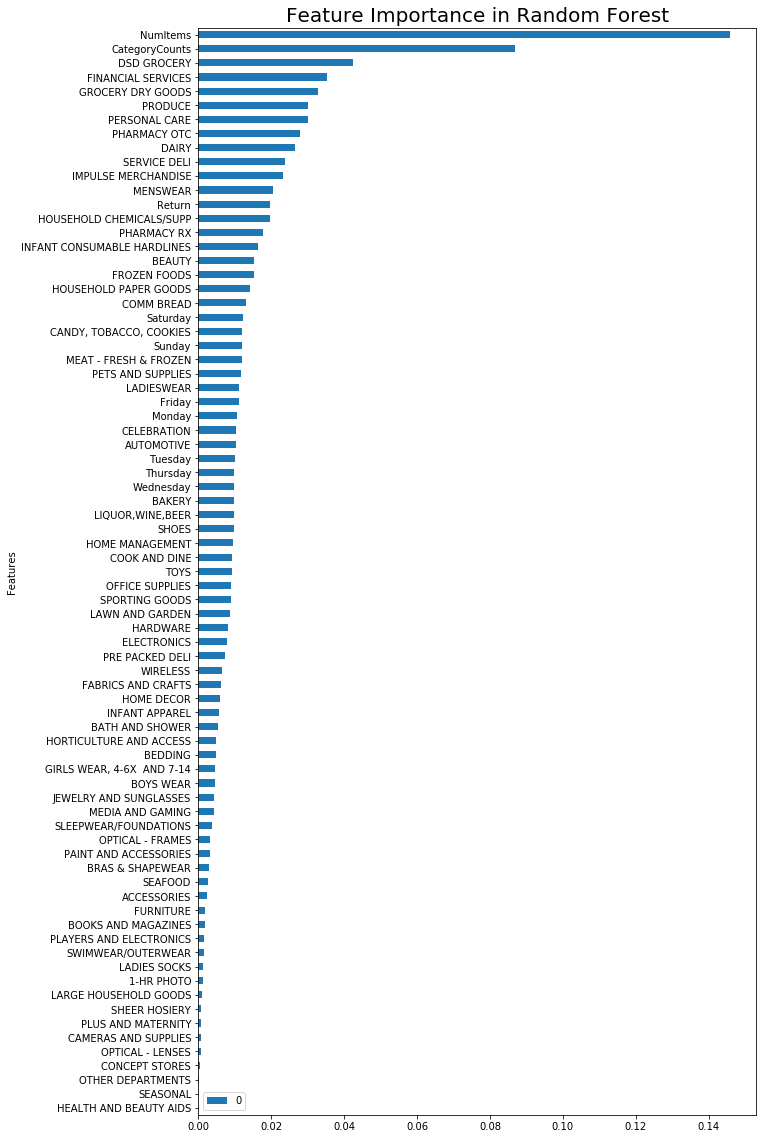

In [19]:
graphing_results = pd.DataFrame(rfc.feature_importances_)
graphing_results["Features"] = X.columns
graphing_results = graphing_results.set_index("Features").sort_values(by=0, ascending=True)
graphing_results.plot(kind="barh", figsize=(10,20), rot=0)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.title("Feature Importance in Random Forest", size=20)

In [20]:
df = graphing_results.loc[["NumItems", "CategoryCounts", "Return"]]
df_DayofWeek = pd.DataFrame({"DayofWeek": np.sum(graphing_results.loc[weekdays])})
df_Dept = pd.DataFrame({"DepartmentofPurchase": np.sum(graphing_results.loc[dept_list])}) 
df = df.append(df_DayofWeek.T)
df = df.append(df_Dept.T)
df = df.sort_values(by=0, ascending=False)
df

,0
DepartmentofPurchase,0.671548
NumItems,0.145753
CategoryCounts,0.086850
DayofWeek,0.076148
Return,0.019701


Text(0.5, 1.0, 'Feature Importance in Random Forest')

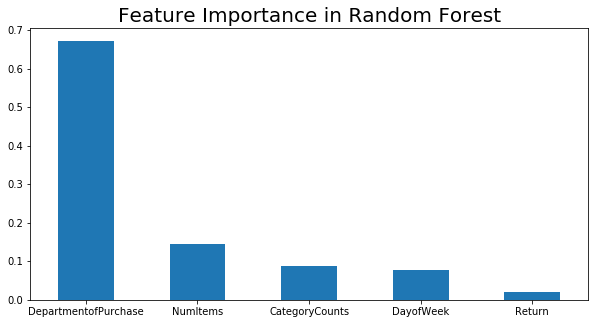

In [21]:
df.plot(kind="bar", figsize=(10,5), rot=0, legend=False)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.title("Feature Importance in Random Forest", size=20)

In [22]:
scoring = ['neg_log_loss', 'accuracy']

In [35]:
params = {'bootstrap': [True, False], 'max_depth': np.arange(50, 100, 10), 'min_samples_split': [3, 5, 7, 9],  
          'min_samples_leaf': [2, 4, 6, 8], 'max_features': ['auto', 'sqrt'], 'n_estimators': [100]}
RS = RandomizedSearchCV(rfc, param_distributions = params, scoring=scoring, cv = 4, 
                        n_iter = 100, refit='accuracy', random_state=42, n_jobs = -1)

In [36]:
start = time.time()
RS.fit(X, y)
end = time.time()
end - start

40878.21320080757

In [37]:
pd.DataFrame(RS.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_min_samples_split',
       'param_min_samples_leaf', 'param_max_features', 'param_max_depth',
       'param_bootstrap', 'params', 'split0_test_neg_log_loss',
       'split1_test_neg_log_loss', 'split2_test_neg_log_loss',
       'split3_test_neg_log_loss', 'mean_test_neg_log_loss',
       'std_test_neg_log_loss', 'rank_test_neg_log_loss',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy'],
      dtype='object')

In [38]:
RS.best_params_

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [39]:
RS.best_score_

0.6832263728912766

In [46]:
cols = ['rank_test_neg_log_loss', 'mean_test_neg_log_loss', 'rank_test_accuracy', 'mean_test_accuracy', 'param_bootstrap', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'param_max_depth', ]
df = pd.DataFrame(RS.cv_results_)

In [49]:
df.loc[df.rank_test_accuracy <= 12, cols]

,rank_test_neg_log_loss,mean_test_neg_log_loss,rank_test_accuracy,mean_test_accuracy,param_bootstrap,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth
9,8,-1.019521,5,0.683028,False,3,2,auto,70
13,8,-1.019521,5,0.683028,False,3,2,sqrt,70
36,13,-1.023998,1,0.683226,False,3,2,sqrt,50
41,4,-1.017265,10,0.682620,False,5,2,auto,60
47,10,-1.019561,3,0.683111,False,7,2,auto,60
48,3,-1.016811,8,0.682756,False,7,2,auto,70
49,14,-1.024496,9,0.682735,False,5,2,sqrt,50
52,1,-1.014689,12,0.682495,False,5,2,auto,90
60,10,-1.019561,3,0.683111,False,7,2,sqrt,60
63,2,-1.016636,11,0.682516,False,7,2,auto,80


In [53]:
params = {'bootstrap': [False], 'max_depth': np.arange(30, 90, 10), 'min_samples_split': [3, 5, 7, 9],  
          'min_samples_leaf': [2], 'max_features': ['log2', 'sqrt'], 'n_estimators': [100]}
RS_new = RandomizedSearchCV(rfc, param_distributions = params, scoring=scoring, cv = 4, 
                        n_iter = 30, refit='accuracy', return_train_score=True, random_state=42, n_jobs = -1)

In [54]:
start = time.time()
RS_new.fit(X, y)
end = time.time()
end - start

3681.591612100601

In [57]:
RS_new.best_params_

{'n_estimators': 100,
 'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

In [58]:
RS_new.best_score_

0.6831113991261993

In [62]:
params = {'bootstrap': [False], 'max_depth': np.arange(10, 50, 10), 'min_samples_split': [2, 3, 5, 7, 9],  
          'min_samples_leaf': [2], 'max_features': ['sqrt'], 'n_estimators': [100]}
GS = GridSearchCV(rfc, param_grid = params, scoring=scoring, cv = 4, 
                refit='accuracy', return_train_score=True, n_jobs = -1)

In [63]:
start = time.time()
GS.fit(X, y)
end = time.time()
end - start

2467.6692304611206

In [64]:
GS.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

In [65]:
GS.best_score_

0.6817108096243494